In [ ]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()

# We'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
import coco
from utils import *


In [ ]:
# load testing data
import io
data_dir = "dataset/"
val_dir = "dataset/val2014"
test_dir = "dataset/test2014"

def load_test():
    filename = "image_info_test2014.json"
    path = os.path.join(data_dir, "annotations", filename)
    with io.open(path, "r", encoding="utf-8") as file:
        data_raw = json.load(file)
        
    images = data_raw['images']
    records = dict()
    
    for image in images:
        image_id = image['id']
        filename = test_dir + '/' + image['file_name']
        record = dict()
        record['filename'] = filename
        records[image_id] = record
    
    records_list = [(key, record['filename'])
                    for key, record in sorted(records.items())]
    
    ids, filenames = zip(*records_list)
    return ids, filenames

def load_records(val = True):
    image_ids = []
    
    filename = "captions_val2014.json"
    path = os.path.join(data_dir, "annotations", filename)

    with io.open(path, "r", encoding="utf-8") as file:
        data_raw = json.load(file)

    images = data_raw['images']
    annotations = data_raw['annotations']

    records = dict()

    for image in images:
        image_id = image['id']
        filename = val_dir + '/' + image['file_name']
        record = dict()
        record['filename'] = filename
        record['captions'] = list()
        records[image_id] = record

    for ann in annotations:
        image_id = ann['image_id']
        caption =  ann['caption']
        
        record = records[image_id]
        record['captions'].append(caption)
        
    
    records_list = [(key, record['filename'], record['captions'])
                    for key, record in sorted(records.items())]

    ids, filenames, captions = zip(*records_list)

    return ids, filenames, captions

In [ ]:
test_ids, filenames_test = load_test()
filenames_test = list(filenames_test)
test_ids = list(test_ids)

In [ ]:
""" Testing set"""
_, filenames_test, captions_test = load_records(False)

**Load Data**

In [5]:
""" Training set set"""
_, all_filenames_train, all_captions_train = coco.load_records(train=True)

- Data loaded from cache-file: dataset/records_train_2014.pkl


In [6]:
all_filenames_train[0]

u'dataset/train2014/COCO_train2014_000000000009.jpg'

In [7]:
""" Remove captions > 5"""
all_cap = []
for i  in range (0, len(all_captions_train)):
        all_cap.append(all_captions_train[i][0:5])
        
all_captions_train = all_cap

In [8]:
""" Validation set"""
val_ids , filenames_val, captions_val = load_records(True)
filenames_val = list(filenames_val)
captions_val = list(captions_val)
val_ids = list(val_ids)

In [9]:
print(len(val_ids))
print(filenames_val[0])

40504
dataset/val2014/COCO_val2014_000000000042.jpg


In [10]:
""" Shuffle training data"""
all_captions_train, all_filenames_train = shuffle(all_captions_train,
                                          all_filenames_train,
                                          random_state=1)

# selecting the first 30000 captions from the shuffled set
num_examples = len(all_filenames_train)-31     # just to make it dividable by the batch size
captions_train = all_captions_train[:num_examples]
filenames_train = all_filenames_train[:num_examples]

In [11]:
print(num_examples)
assert(num_examples % 32 == 0)

82752


a close up of a child holding a closed umbrella
A kid holding an umbrella looking at a camera
A small child is holding an umbrella in front of the door.
A child is holding an umbrella in front of a door.
A boy holds a polka dot umbrella near a door and peeks through the hole the handle makes.
dataset/train2014/COCO_train2014_000000211234.jpg


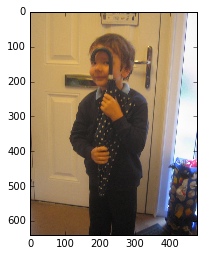

In [12]:
show_image(filenames_train, captions_train, idx = 0, train=True)

**Transfer Model**

In [13]:
all_transfer_models = ['vgg16', 'resnet', 'inception']   # Specify transfer model for encoder network
transfer_model = all_transfer_models[2]                           

In [ ]:
if (transfer_model == 'inception'):
    image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=(299,299,3))
    img_size = 299                               # default input size for inception
    preprocess = tf.keras.applications.inception_v3.preprocess_input
    
elif (transfer_model =='resnet'):
    image_model = tf.keras.applications.ResNet50(include_top=False,weights='imagenet')
    preprocess  = tf.keras.applications.resnet50.preprocess_input
    img_size = 224                              # default input size for resnet
else :
    image_model = tf.keras.applications.VGG16(include_top = False, weights = 'imagenet', input_shape = (224, 224,3))
    preprocess  = tf.keras.applications.vgg16.preprocess_input
    img_size = 224                             # default input size for vgg16
            
input_img_size = image_model.input                   # input size for transfer model
transfer_layer_size = image_model.layers[-1].output  # features size for transfer model

features_transfer_model = tf.keras.Model(input_img_size, transfer_layer_size)
image_model.summary()

In [ ]:
print('Image size: {size} '.format(size = tf.keras.backend.int_shape(input_img_size)))
print('Encoded Features size ( {model} ) :  {size} '.format(model = transfer_model,size =  tf.keras.backend.int_shape(transfer_layer_size)))

In [13]:
def load_image(image_path):
    img = tf.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize_images(img, (img_size, img_size))
    img = preprocess(img)                                 # for inceptionv3 img shape (299, 299, 3)
    return img, image_path

**Caching the features extracted from the transfer model**

In [ ]:
# training data
image_dataset = tf.data.Dataset.from_tensor_slices(all_filenames_train).map(load_image).batch(16)

for img, path in image_dataset:
    batch_features = features_transfer_model(img)
    batch_features = tf.reshape(batch_features, 
                              (batch_features.shape[0], -1, batch_features.shape[3]))
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

In [ ]:
# cache validation data
val_image_dataset = tf.data.Dataset.from_tensor_slices(filenames_val).map(load_image).batch(16)

for img, path in val_image_dataset:
    batch_features = features_transfer_model(img)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

In [112]:
# cache test set
test_image_dataset = tf.data.Dataset.from_tensor_slices(filenames_test).map(load_image).batch(16)

for img, path in test_image_dataset:
    batch_features = features_transfer_model(img)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

**Tokenization : captions**

In [14]:
from tokenizer import *
"""Add start and end tokens to ALL CAPTIONS"""
captions_train_marked = add_se_tokens(captions_train)
captions_train_marked[0]

[u'start a close up of a child holding a closed umbrella end',
 u'start A kid holding an umbrella looking at a camera end',
 u'start A small child is holding an umbrella in front of the door. end',
 u'start A child is holding an umbrella in front of a door. end',
 u'start A boy holds a polka dot umbrella near a door and peeks through the hole the handle makes. end']

In [15]:
one_cap = []
for captions_list in captions_train_marked :
        one_cap.append([captions_list[0]])

In [ ]:
print(one_cap[1])

In [16]:
""" Flatten the captions"""
captions_train_flat = flatten(captions_train_marked)
captions_train_flat[0:10]

[u'start a close up of a child holding a closed umbrella end',
 u'start A kid holding an umbrella looking at a camera end',
 u'start A small child is holding an umbrella in front of the door. end',
 u'start A child is holding an umbrella in front of a door. end',
 u'start A boy holds a polka dot umbrella near a door and peeks through the hole the handle makes. end',
 u'start Two skis are seen from above from the perspective of the skier. end',
 u'start A pair of skis in the snow on a field. end',
 u'start A pair of skis riding along a snow covered ground. end',
 u"start Looking down at a pair of skis on snow from skier's viewpoint end",
 u'start Two ski shoes lay in a patch of snow.  end']

In [17]:
num_words = 10000
tokenizer = TokenizerWrap(texts=captions_train_flat,
                          num_words=num_words)

In [18]:
token_start = tokenizer.word_index[start_token.strip()]
token_start

4

In [19]:
print(len(tokenizer.word_index))

10000


In [22]:
token_end = tokenizer.index_to_word[9999]
token_end

u'bystander'

In [24]:
tokenizer.word_index['<pad>']

0

In [25]:
text= [['my dkktr os']]
tokenizer.captions_to_tokens(text)

[[[3887, 1, 6308]]]

In [26]:
tokens_train = tokenizer.captions_to_tokens(captions_train_marked)

In [27]:
tokens_train[0]

[[4, 2, 127, 35, 6, 2, 154, 27, 2, 868, 131, 3],
 [4, 2, 445, 27, 15, 131, 72, 18, 2, 268, 3],
 [4, 2, 37, 154, 11, 27, 15, 131, 8, 41, 6, 7, 295, 3],
 [4, 2, 154, 11, 27, 15, 131, 8, 41, 6, 2, 295, 3],
 [4,
  2,
  79,
  258,
  2,
  2021,
  2150,
  131,
  38,
  2,
  295,
  10,
  3189,
  103,
  7,
  959,
  7,
  1339,
  1036,
  3]]

In [28]:
""" Pad tokens with zeros """
max_tokens = 0
for cap in tokens_train:
    tokens_num = [len(t) for t in cap]
    if (tokens_num[np.argmax(tokens_num)] > max_tokens):
        max_tokens = tokens_num[np.argmax(tokens_num)]
        
for i  in range (len(tokens_train)):
    tokens_train[i] = tf.keras.preprocessing.sequence.pad_sequences(tokens_train[i], maxlen=max_tokens,padding='post',truncating='post').tolist()


In [ ]:
"""
# Select a random caption 
tokens_seq = []

for t in tokens_train:
    j = np.random.randint(0,len(t))
    tokens_seq.append(t[j])

# padd with the max length
num_tokens = [len(t) for t in tokens_seq]
        
# Max number of tokens.
max_tokens = np.max(num_tokens)
# Pad all the other token-sequences with zeros
# so they all have the same length and can be
# input to the neural network as a numpy array.
tokens_padded = tf.keras.preprocessing.sequence.pad_sequences(tokens_seq, maxlen=max_tokens,padding='post',truncating='post')"""

**Creating Tensorflow Dataset Pipeline**

In [29]:
for t in tokens_train: 
    if (len(t) is not 5):
        print(len(t))

In [30]:
# loading the numpy files and choosing a random caption from the 5 captions of the image or returns all captions
def parse_func(img_name, cap, all_captions = False):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    if (all_captions):     # map all the five captions to the image
        caption = cap
    else:                  # else map a randomly chosen caption from the 5 captions
        j = np.random.randint(0 , len(cap))
        caption = cap[j]
    return img_tensor, caption

In [31]:
batch_size = 32
buffer_size = len(filenames_train)                  # for shuffeling dataset

In [32]:
print("num images train ", len(filenames_train))
print("num caption train" , len(tokens_train))
print("num of vocabs", len(tokenizer.word_index))

assert(num_examples % batch_size==0)

('num images train ', 82752)
('num caption train', 82752)
('num of vocabs', 10000)


In [33]:
dataset = tf.data.Dataset.from_tensor_slices((filenames_train,tokens_train))

dataset = dataset.shuffle(buffer_size)

dataset = dataset.map(lambda item1, item2: tf.py_func(
          parse_func, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=8)

# Batching and prefetching
dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(1)                     # prefetch one batch to make sure it's ready during training

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    


** Image Captioning Model**

In [ ]:
# https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/contrib/eager/python/examples/generative_examples/image_captioning_with_attention.ipynb#scrollTo=oJGE34aiRPFo

In [34]:
embedding_dim = 256                                 # embedding layer dimensions
units = 512                                         # rnn decoder number of units
vocab_size = len(tokenizer.word_index)               # number of words in the vocab dictionary

# shape of the vector extracted from transfer, InceptionV3 is (64, 2048), vgg is (), resnet is ()
features_shape = tf.keras.backend.int_shape(transfer_layer_size)[3] 
attention_features_shape = tf.keras.backend.int_shape(transfer_layer_size)[1] * tf.keras.backend.int_shape(transfer_layer_size)[2]

In [35]:
num_captions_train = [len(captions) for captions in tokens_train]
total_num_captions_train = np.sum(num_captions_train)
steps_per_epoch = int(total_num_captions_train / batch_size)
steps_per_epoch

12930

In [36]:
enumerate_steps = len(filenames_train) / batch_size
steps_per_enumerate = steps_per_epoch / enumerate_steps
steps_per_enumerate 

5

In [37]:
print(features_shape)
print(attention_features_shape)
print(vocab_size)

2048
64
10000


In [38]:
""" RNN Cells. CuDNNGRU layer and CudNNLSTM are fast implementations that run on the GPU"""
def gru(units):
    if tf.test.is_gpu_available():     # if GPU is available use GPU version
        return tf.keras.layers.CuDNNGRU(units, 
                                    return_sequences=True, 
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')
    else:
        return tf.keras.layers.GRU(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='sigmoid', 
                               recurrent_initializer='glorot_uniform')
    
def lstm(units):
    if tf.test.is_gpu_available():
        return tf.keras.layers.CuDNNLSTM(units,
                                         recurrent_initializer='glorot_uniform',
                                         return_sequences = True,
                                         return_state = True)
    else:
        return tf.keras.layers.LSTM(units, 
                                    return_sequence = True,
                                    return_state= True,
                                    activation='tanh',
                                    recurrent_activation='hard_sigmoid',
                                    recurrent_initializer='glorot_uniform')

In [39]:
"""Subclassed from keras model class"""
class SoftAttention(tf.keras.Model):
    
    def __init__(self, units):
        super(SoftAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)        # weights for the encoded features 
        self.W2 = tf.keras.layers.Dense(units)        # weights for the hidden state of the previous time step
        self.V  = tf.keras.layers.Dense(1)
  
    """ Input : hidden state of the previous time step s<t-1> , a<t`> : activations from the encoder """
    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)
        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
    
        # score shape == (batch_size, 64, hidden_size)
        # tanh activation : high values --> very small differences , small values as well
        # mi = tanh(yW1 + CWc)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
    
        """ softmax layer to output the probability of paying attention to certain parts in the features encoded """
        # attention_weights shape == (batch_size, 64, 1)
        # we get 1 at the last axis because we are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
    
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features            # multiplying the probabilty of paying attention by the encoded features
        context_vector = tf.reduce_sum(context_vector, axis=1)  # summing all the regions of interest to get a final output representing parts of the image we should pay attention to
    
        return context_vector, attention_weights

In [40]:
class CNN_Encoder(tf.keras.Model):
    # Since we have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)
        
    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x
    
    def save(self, folder_to_save = 'models/CNN_encoder/'):
        saver = tfe.Saver(self.variables)
        saver.save(folder_to_save)
        
    def load(self, folder_where_saved = 'models/CNN_encoder/'):
        saver = tfe.Saver(self.variables)
        saver.restore(folder_where_saved)

In [41]:
class RNN_Decoder(tf.keras.Model):
    
    def __init__(self, embedding_dim, units, vocab_size, cell = 'gru', attention = True):
        super(RNN_Decoder, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.rnn_type = cell
        
        if(cell is 'gru'):
            self.rnn_cell = gru(self.units)
        else:
            self.rnn_cell = lstm(self.units)
            print('lstm')
            
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        self.attention = SoftAttention(self.units)
        
    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)
    
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
    
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the rnn cell
        # print(self.rnn_cell(x))
        
        if self.rnn_type is 'gru':
            output, state = self.rnn_cell(x)
        else:                                               # LSTM has two state outputs : cell state & mem state
            output, state_h, state_c = self.rnn_cell(x)
            state = state_h
            
        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)
    
        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))
    
        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))
    
    def save(self, folder_to_save = 'models/RNN_decoder/'):
        saver = tfe.Saver(self.variables)
        saver.save(folder_to_save)
        
    def load(self, folder_where_saved = 'models/RNN_decoder/'):
        saver = tfe.Saver(self.variables)
        saver.restore(folder_where_saved)

In [117]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size, 'gru')

In [118]:
optimizer = tf.train.AdamOptimizer()

# We are masking the loss calculated for padding
def loss_function(real, pred):
    mask = 1 - np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
    #if (tf.reduce_mean(loss_) is np.nan or tf.reduce_mean(loss_)  != tf.reduce_mean(loss_)  ):
      #  print(real)
       # print(pred)
      #  print(pred.shape)
    return tf.reduce_mean(loss_)

In [119]:
# adding this in a separate cell because if you run the training cell 
# many times, the loss_plot array will be reset
loss_plot = []

In [120]:
print(encoder.variables)
print(decoder.variables)

[]
[]


In [ ]:
checkpoint_dir = 'path/to/encoder_model_dir'
tf.train.latest_checkpoint(checkpoint_dir)

In [121]:
checkpoint_dir = 'path/to/encoder_model_dir_one_cap_one_image_gru_all_2014'
checkpoint_dir2 = 'path/to/decoder_model_dir_one_cap_one_image_gru_all_2014'

#os.makedirs(checkpoint_dir)
#os.makedirs(checkpoint_dir2)

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint_prefix2 = os.path.join(checkpoint_dir2,"ckpt")

checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=encoder)

checkpoint2 = tf.train.Checkpoint(optimizer=optimizer, model=decoder)

status = checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
status2 = checkpoint2.restore(tf.train.latest_checkpoint(checkpoint_dir2))


In [173]:
EPOCHS = 20
steps_per_enumerate = 1

for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0
    num_batches = 0
    
    for i in range(steps_per_enumerate):

        for (batch, (img_tensor, target)) in enumerate(dataset):
            loss = 0
            num_batches = num_batches + 1
            # initializing the hidden state for each batch
            # because the captions are not related from image to image
            hidden = decoder.reset_state(batch_size=target.shape[0])
            # repeat start token with the number of images in the batch 
            # 1D vecotr of dimenstions (batch_size ,1 )
            #dec_input = np.repeat(list([tokenizer.word_index['start']]), batch_size, axis =0).reshape(batch_size, 1)
            dec_input = tf.expand_dims([tokenizer.word_index['start']] * batch_size, 1)
                 
            with tf.GradientTape() as tape:
                # Extract image features from transfer layer and pass it to a fully connected layer
                features = encoder(img_tensor)
            
                for i in range(1, target.shape[1]):  # loop over all words in the caption
                    # passing the features through the decoder
                    predictions, hidden, _ = decoder(dec_input, features, hidden)

                    loss += loss_function(target[:, i], predictions)
                
                    # using teacher forcing
                    dec_input = tf.expand_dims(target[:, i], 1)   # shift tokens one time step 
        
            total_loss += (loss / int(target.shape[1]))   # divided by number of words in the sentence
        
           # print(loss)
            variables = encoder.variables + decoder.variables
            gradients = tape.gradient(loss, variables) 
           # print(gradients)
            
            #clipped_grads_and_vars = [(tf.clip_by_norm(gradients[i], 1), variables[i]) for i in range(len(gradients))]
           # capped_gvs = [(tf.clip_by_value(gradients[i], -1., 1.), variables[i]) for i in range(len(gradients))]
            
            optimizer.apply_gradients(zip(gradients, variables), tf.train.get_or_create_global_step())
        
            if batch % 100 == 0:
                print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, 
                                                              batch, 
                                                             loss.numpy() / int(target.shape[1])))            
    if epoch  == 20:
        checkpoint.save(checkpoint_prefix)
        checkpoint2.save(checkpoint_prefix2)
        
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss /  num_batches)
    
    print ('Epoch {} Loss {:.6f}'.format(epoch + 1, 
                                         total_loss/ num_batches))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))\

Epoch 1 Batch 0 Loss 0.2977
Epoch 1 Batch 100 Loss 0.3084
Epoch 1 Batch 200 Loss 0.3286
Epoch 1 Batch 300 Loss 0.2669
Epoch 1 Batch 400 Loss 0.3191
Epoch 1 Batch 500 Loss 0.2596
Epoch 1 Batch 600 Loss 0.2903
Epoch 1 Batch 700 Loss 0.2904
Epoch 1 Batch 800 Loss 0.2833
Epoch 1 Batch 900 Loss 0.2875
Epoch 1 Batch 1000 Loss 0.3293
Epoch 1 Batch 1100 Loss 0.2981
Epoch 1 Batch 1200 Loss 0.3446
Epoch 1 Batch 1300 Loss 0.2569
Epoch 1 Batch 1400 Loss 0.4501


KeyboardInterrupt: 

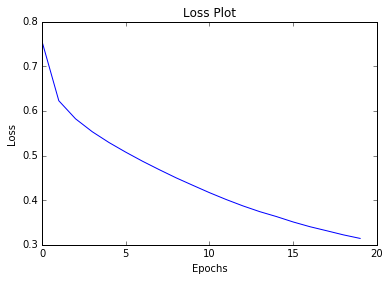

In [48]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [49]:
checkpoint.save(checkpoint_prefix)
checkpoint2.save(checkpoint_prefix2)

Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than editing the Checkpoint proto manually.


'path/to/decoder_model_dir_one_cap_one_image_gru_all_2014/ckpt-1'

** Validation & Testing dataset**

In [170]:
def parse_func_val(img_name, img_id):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor , img_id

# Validation dataset
dataset_val = tf.data.Dataset.from_tensor_slices((filenames_val[0:2], val_ids[0:2]))

dataset_val = dataset_val.map(lambda item1 , item2: tf.py_func(
          parse_func_val, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=8)

In [113]:
# Test dataset
dataset_test = tf.data.Dataset.from_tensor_slices((filenames_test, test_ids))
dataset_test = dataset_test.map(lambda item1, item2: tf.py_func(
               parse_func_val, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls = 8)

In [79]:
def evaluate_cached(dataset):

    captions = []
    for img_tensor_val, img_id in dataset:
        
        hidden = decoder.reset_state(batch_size=1)
        features = encoder(img_tensor_val)
        dec_input = tf.expand_dims([tokenizer.word_index['start']], 0)
        
        result = [] 
        for i in range(max_length):
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

            predicted_id = tf.argmax(predictions[0]).numpy()
            result.append(tokenizer.index_word[predicted_id])

            if tokenizer.index_word[predicted_id] == 'end':
                result = result[:-1]
                break

            dec_input = tf.expand_dims([predicted_id], 0)
        
        captions.append({"image_id": int(img_id), "caption": str(' '.join(result))})

    return captions

In [171]:
max_length = 51
captions_val = evaluate_cached(dataset_val)

In [172]:
captions_val

[{'caption': u'a small brown teddy bear sitting on a chair', 'image_id': 42},
 {'caption': u'a row of motorcycles parked next to a parked bike',
  'image_id': 73}]

In [122]:
captions_test = evaluate_cached(dataset_test)

In [151]:
captions_val_res = captions_val

In [131]:
captions_test[119]

{'caption': u'a group of people walk down a narrow city', 'image_id': 1585}

**JSON File result**

** Evaluate Generated Captions**

In [85]:
%matplotlib inline
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap
import matplotlib.pyplot as plt
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

import json
from json import encoder
encoder.FLOAT_REPR = lambda o: format(o, '.3f')

In [86]:
dataDir='.'
dataType_val='val2014'
dataType_test = 'test2014'

algName  = 'one_cap_one_img_gru_all_2014'

annFile_val  = '%s/dataset/annotations/captions_%s.json'%(dataDir, dataType_val)
annFile_test = '%s/dataset/annotations/captions_%s.json'%(dataDir, dataType_test)

subtypes_val = ['results', 'evalImgs', 'eval']
[resFile_val, evalImgsFile_val, evalFile_val]= \
['%s/results/captions_%s_%s_%s.json'%(dataDir,dataType_val,algName,subtype) for subtype in subtypes_val]

subtypes_test = ['results', 'evalImgs', 'eval']
[resFile_test, evalImgsFile_test, evalFile_test]= \
['%s/results/captions_%s_%s_%s.json'%(dataDir,dataType_test,algName,subtype) for subtype in subtypes_test]

# download Stanford models
!./get_stanford_models.sh

Found Stanford CoreNLP.


In [87]:
""" Write results val & test to a JSON file"""
import json
with open(resFile_val, 'w') as outfile:
    json.dump(captions_val, outfile)

In [132]:
with open(resFile_test, 'w') as outfile:
    json.dump(captions_test, outfile)

In [139]:
# Add type key to the captions json file 
with open(annFile_val) as json_file:
    json_decoded = json.load(json_file)

json_decoded['type'] = 'captions'

with open(annFile_val, 'w') as json_file:
    json.dump(json_decoded, json_file)

In [141]:
# create coco object and cocoRes object for val
coco_val = COCO(annFile_val)
cocoRes_val = coco_val.loadRes(resFile_val)

loading annotations into memory...
0:00:00.461087
creating index...
index created!
Loading and preparing results...     
DONE (t=0.16s)
creating index...
index created!


In [142]:
# Evaluate validation
cocoEval_val = COCOEvalCap(coco_val, cocoRes_val)
print(len(cocoRes_val.getImgIds()))
# evaluate results
# SPICE will take a few minutes the first time, but speeds up due to caching
cocoEval_val.evaluate()

40504
tokenization...
setting up scorers...
computing Bleu score...
{'reflen': 387542, 'guess': [461781, 421277, 380773, 340284], 'testlen': 461781, 'correct': [216028, 93999, 36857, 14231]}
ratio: 1.19156375309
Bleu_1: 0.468
Bleu_2: 0.323
Bleu_3: 0.216
Bleu_4: 0.143
computing METEOR score...
METEOR: 0.183
computing Rouge score...
ROUGE_L: 0.426
computing CIDEr score...
CIDEr: 0.503
computing SPICE score...
SPICE: 0.124


In [143]:
# print output evaluation scores for val
for metric, score in cocoEval_val.eval.items():
    print '%s: %.3f'%(metric, score)

CIDEr: 0.503
Bleu_4: 0.143
Bleu_3: 0.216
Bleu_2: 0.323
Bleu_1: 0.468
ROUGE_L: 0.426
METEOR: 0.183
SPICE: 0.124


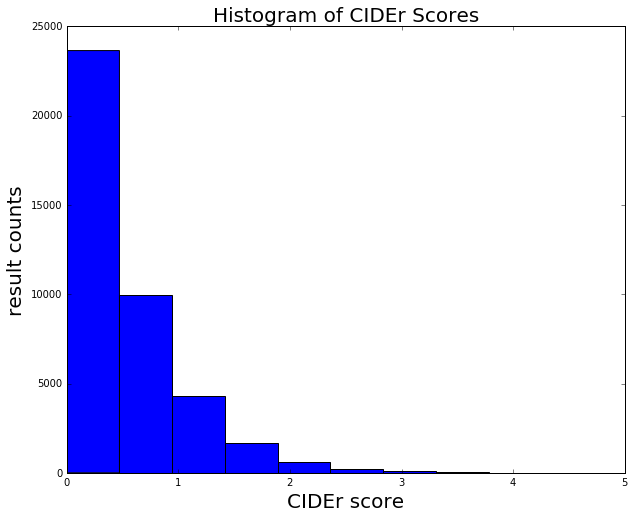

In [144]:
# plot score histogram
ciderScores = [eva['CIDEr'] for eva in cocoEval_val.evalImgs]
plt.hist(ciderScores)
plt.title('Histogram of CIDEr Scores', fontsize=20)
plt.xlabel('CIDEr score', fontsize=20)
plt.ylabel('result counts', fontsize=20)
plt.show()

In [145]:
# save evaluation results to ./results folder
json.dump(cocoEval_val.evalImgs, open(evalImgsFile_val, 'w'))
json.dump(cocoEval_val.eval,     open(evalFile_val, 'w'))

** Attention Plots**

In [146]:
def evaluate(image , beam_search = False, beam_width = 3):
    attention_plot = np.zeros((max_length, 64))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = features_transfer_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    
    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['start']], 0)
    result = []
    pred  = []
    
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == 'end':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)
        
        probs = tf.nn.softmax(predictions)
        
        pred.append(np.log(probs))
        
    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot


def beam_search_decoder(data, k):
    
    sequences = [[list(), 1.0]]
    for row in data:
        row = tf.nn.softmax(row, axis = 1)
        all_candidates = list()
        for i in range(len(sequences)): 
            #rint (sequences[i])
            seq, score = sequences[i]
            for j in range(row[0].shape[0]): 
                candidate = [seq + [j], score * -log(np.array(row[0][j]))]
                all_candidates.append(candidate)
        ordered = sorted(all_candidates, key=lambda tup:tup[1])
        sequences = ordered[:k]
    return sequences

In [147]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))
    fig = plt.figure(figsize=(12,12))
    
    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

('Real Caption:', [u'A hot dog and a pickle on a tray.', u'A hotdog that is sitting in a bun on a paper.', u'A hot dog with pickles and tomatoes. ', u'there is a sandwich with many different foods in it', u'This is a hot dog with tomato, mustard, onion, relish, and pickle on it.'])
('Prediction Caption:', u'a hotdog with peppers onions and tomatoes on a bun with carrots and cheese hotdogs inside of a wrapper end')


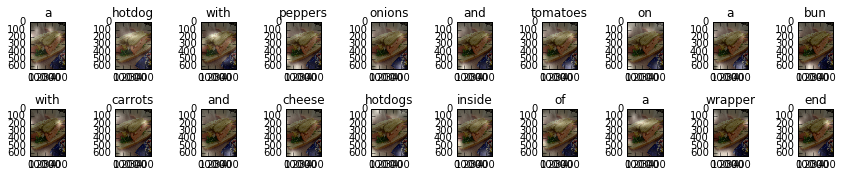

('Prediction Caption:', u'a hotdog with peppers onions and tomatoes on a bun with carrots and cheese hotdogs inside of a wrapper end')


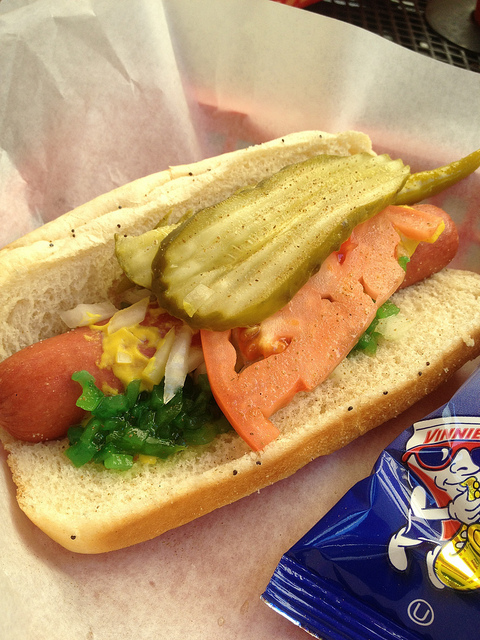

In [202]:
rid = np.random.randint(0, len(filenames_val))
image = filenames_val[rid]
real_caption = captions_val[rid]
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
# opening the image
print ('Prediction Caption:', ' '.join(result))
Image.open(filenames_val[rid])